In [1]:
import sys
import os
import torch
import numpy as np
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)
from ssast_model import ASTModel
import soundfile as sf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchaudio
import pickle
import librosa

In [2]:
# Verify the file path is correct
file_path = '/home/bosfab01/SpeakerVerificationBA/data/preprocessed/0a4b5c0f-facc-4d3b-8a41-bc9148d62d95/0_segment_0.flac'
try:
    audio_signal, sample_rate = sf.read(file_path)
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    raise

# Create time array for plotting
time = np.arange(len(audio_signal)) / sample_rate

# Print information about the audio
print("Time of last sample:", time[-1])
print("Number of samples:", len(audio_signal))
print("Sample rate:", sample_rate)
print("Duration of audio:", len(audio_signal) / sample_rate)
print("Shape of audio signal:", audio_signal.shape)
print("Type of audio signal:", type(audio_signal))
print("Data type of audio signal:", audio_signal.dtype)


# Convert the NumPy array to a PyTorch tensor
audio_tensor = torch.from_numpy(audio_signal)
print("Type of audio tensor:", type(audio_tensor))
print("Data type of audio tensor:", audio_tensor.dtype)
print("Shape of audio tensor:", audio_tensor.shape)

# Ensure the tensor is in float32 format (required for most torchaudio operations)
audio_tensor = audio_tensor.float()
print("Data type of audio tensor:", audio_tensor.dtype)

# If your array is not in batch x channels x time format, adjust accordingly
# Assuming the audio signal is single-channel and not batched:
audio_tensor = audio_tensor.unsqueeze(0)
print("Shape of audio tensor:", audio_tensor.shape)

# Now call the fbank function
fbank_features = torchaudio.compliance.kaldi.fbank(
    audio_tensor, 
    sample_frequency=sample_rate, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Output the shape of the fbank features to confirm
print(f"Shape of fbank features: {fbank_features.shape}")

Time of last sample: 9.9999375
Number of samples: 160000
Sample rate: 16000
Duration of audio: 10.0
Shape of audio signal: (160000,)
Type of audio signal: <class 'numpy.ndarray'>
Data type of audio signal: float64
Type of audio tensor: <class 'torch.Tensor'>
Data type of audio tensor: torch.float64
Shape of audio tensor: torch.Size([160000])
Data type of audio tensor: torch.float32
Shape of audio tensor: torch.Size([1, 160000])
Shape of fbank features: torch.Size([998, 128])


In [3]:
# Assuming audio_signal and sample_rate are defined previously
mel_librosa = librosa.feature.melspectrogram(
    y=audio_signal,  # specify the audio data with keyword argument
    sr=sample_rate,
    n_mels=128,
    hop_length=160,  # 10 ms = 160 * 1/16000
    n_fft=400,       # 25 ms = 400 * 1/16000
    center=False,
    htk=True,
    fmin=0.0,
    fmax=None        # default Nyquist frequency
)

# Print shape, minimum, and maximum value of the mel spectrogram
print(f"Shape of mel spectrogram computed by librosa: {mel_librosa.shape}")
print(f"Minimum value of mel spectrogram computed by librosa: {mel_librosa.min()}")
print(f"Maximum value of mel spectrogram computed by librosa: {mel_librosa.max()}")

# Parameters for inversion to closely match feature extraction settings
sr = sample_rate
n_fft = 400
hop_length = int(0.01 * sr)  # 10 ms
win_length = int(0.025 * sr)  # 25 ms
window = 'hanning'

# Reconstruct the audio without explicitly specifying the length
y = librosa.feature.inverse.mel_to_audio(mel_librosa, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                                         window=window, n_iter=32, htk=True)

# Check the length of the reconstructed audio
print("\nLength of reconstructed audio (samples) using librosa:", len(y))
print("Duration of reconstructed audio (seconds) using librosa:", len(y) / sr)

# save the audio signal
#sf.write('reconstructed_audio_librosa.wav', y, sr)


# Convert tensor fbank_features back to numpy array and transpose it
M = fbank_features.cpu().numpy().T
print("\n\nshape of mel spectrogram computed by torchaudio:", M.shape)
print("min of mel spectrogram computed by torchaudio:", M.min())
print("max of mel spectrogram computed by torchaudio:", M.max())


# Convert tensor fbank_features back to numpy array, transpose, and convert from dB to power
M = fbank_features.cpu().numpy().T
print("min and max of mel spectrogram computed by torchaudio (dB):", M.min(), M.max())
#M_linear = np.exp(M)/np.exp(1)
M_linear = np.exp(M)
print("min and max of mel spectrogram computed by torchaudio (power):", M_linear.min(), M_linear.max())

print("shape of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.shape)
print("min of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.min())
print("max of mel spectrogram computed by torchaudio (adjusted to power):", M_linear.max())

M = M_linear


# Parameters for inversion to closely match feature extraction settings
sr = sample_rate
n_fft = 400
hop_length = int(0.01 * sr)  # 10 ms
win_length = int(0.025 * sr)  # 25 ms
window = 'hanning'

# Reconstruct the audio without explicitly specifying the length
y = librosa.feature.inverse.mel_to_audio(M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
                                         window=window, n_iter=50)

# Check the length of the reconstructed audio
print("\nLength of reconstructed audio (samples):", len(y))
print("Duration of reconstructed audio (seconds):", len(y) / sr)

/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


Shape of mel spectrogram computed by librosa: (128, 998)
Minimum value of mel spectrogram computed by librosa: 0.0
Maximum value of mel spectrogram computed by librosa: 10.826091103215543

Length of reconstructed audio (samples) using librosa: 159520
Duration of reconstructed audio (seconds) using librosa: 9.97


shape of mel spectrogram computed by torchaudio: (128, 998)
min of mel spectrogram computed by torchaudio: -15.942385
max of mel spectrogram computed by torchaudio: 4.2850385
min and max of mel spectrogram computed by torchaudio (dB): -15.942385 4.2850385
min and max of mel spectrogram computed by torchaudio (power): 1.1920935e-07 72.60534
shape of mel spectrogram computed by torchaudio (adjusted to power): (128, 998)
min of mel spectrogram computed by torchaudio (adjusted to power): 1.1920935e-07
max of mel spectrogram computed by torchaudio (adjusted to power): 72.60534

Length of reconstructed audio (samples): 159520
Duration of reconstructed audio (seconds): 9.97


In [4]:
# spectrograms in db
M_librosa_db = librosa.power_to_db(mel_librosa)
print("min and max of mel spectrogram computed by librosa (in dB):", M_librosa_db.min(), M_librosa_db.max())
M_torchaudio_db = librosa.power_to_db(M)
print("min and max of mel spectrogram computed by torchaudio (in dB):", M_torchaudio_db.min(), M_torchaudio_db.max())

print("shape of mel spectrogram computed by librosa (in dB):", M_librosa_db.shape)
print("shape of mel spectrogram computed by torchaudio (in dB):", M_torchaudio_db.shape)

# type of the spectrograms
print("type of mel spectrogram computed by librosa (in dB):", type(M_librosa_db))
print("type of mel spectrogram computed by torchaudio (in dB):", type(M_torchaudio_db))

min and max of mel spectrogram computed by librosa (in dB): -69.65528322574967 10.344716774250331
min and max of mel spectrogram computed by torchaudio (in dB): -61.390312 18.609686
shape of mel spectrogram computed by librosa (in dB): (128, 998)
shape of mel spectrogram computed by torchaudio (in dB): (128, 998)
type of mel spectrogram computed by librosa (in dB): <class 'numpy.ndarray'>
type of mel spectrogram computed by torchaudio (in dB): <class 'numpy.ndarray'>


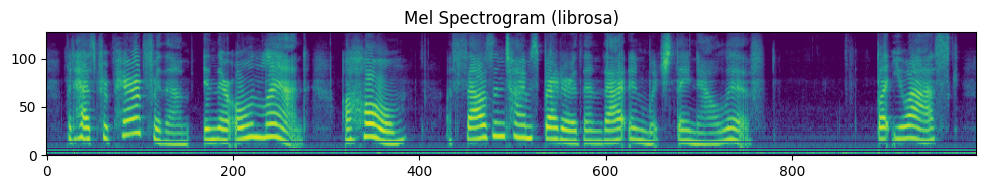

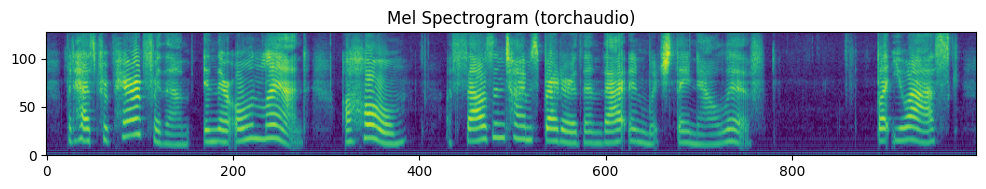

In [5]:
# plot the mel spectrogram computed by librosa on dB scale
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (librosa)')
plt.imshow(M_librosa_db, aspect='auto', origin='lower', cmap='viridis')

# plot the mel spectrogram computed by torchaudio on dB scale
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (torchaudio)')
plt.imshow(M_torchaudio_db, aspect='auto', origin='lower', cmap='viridis')

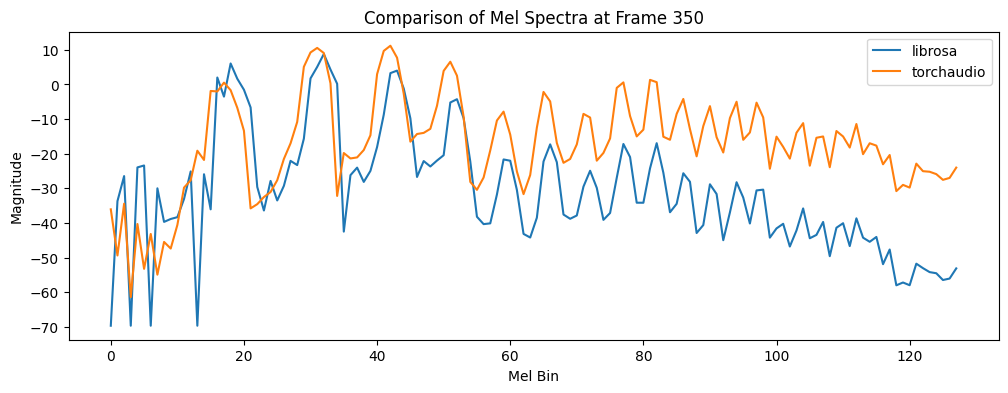

In [6]:

# compare the specta at the 350th frame
plt.figure(figsize=(12, 4))
plt.plot(M_librosa_db[:, 350], label='librosa')
plt.plot(M_torchaudio_db[:, 350], label='torchaudio')
plt.legend()
plt.title('Comparison of Mel Spectra at Frame 350')
plt.xlabel('Mel Bin')
plt.ylabel('Magnitude')
plt.show()

### function to map the torchaudio spectrogram to the same scale as the librosa spectrogram

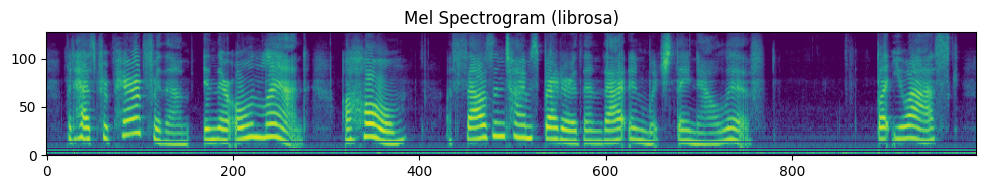

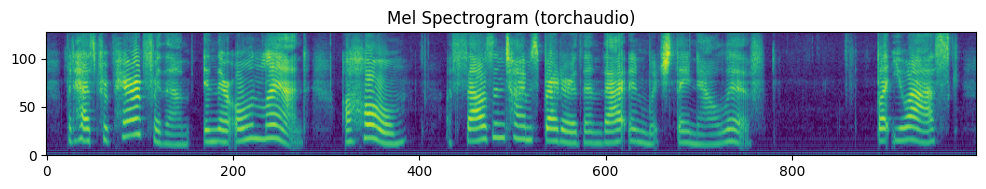

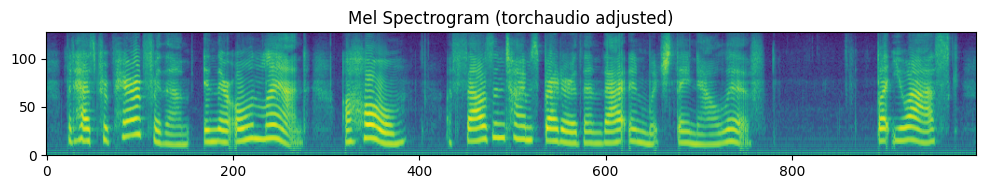

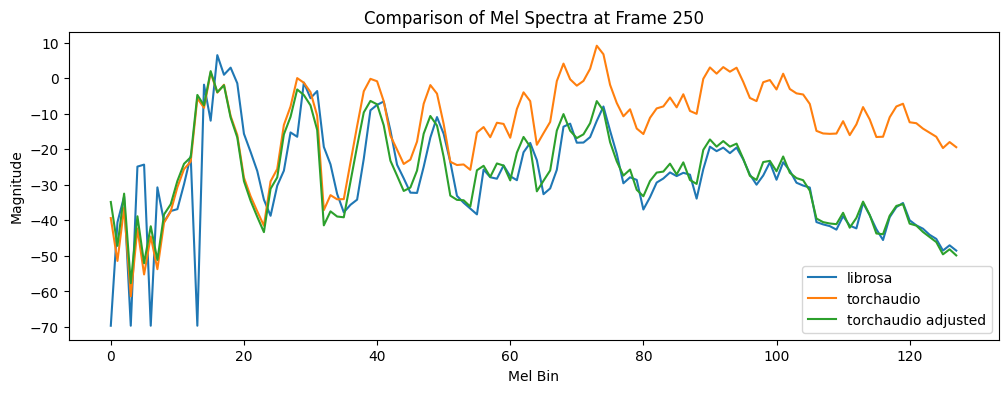

Mean of mel spectrogram computed by librosa (in dB): -43.927267299729465
Mean of mel spectrogram computed by torchaudio (in dB): -30.964945
Mean of mel spectrogram computed by torchaudio (adjusted) (in dB): -43.92726729972948


In [7]:
def transform_spectrogram(librosa_spectrogram, torchaudio_spectrogram_to_fit, torchaudio_spectrogram_to_transform):
    def fit_linear_transform(M1, M2):
        b = M1 - M2
        f_bins, t_frames = M1.shape
        f = np.repeat(np.arange(f_bins), t_frames)
        ones = np.ones(f_bins * t_frames)
        A = np.column_stack((f, ones))
        b = b.flatten()
        A_transpose = A.T
        A_transpose_A = np.dot(A_transpose, A)
        A_transpose_b = np.dot(A_transpose, b)
        x = np.linalg.solve(A_transpose_A, A_transpose_b)
        return x[0], x[1]  # m, q

    # Calculate the transformation parameters m and q using the first torchaudio and librosa spectrograms
    m, q = fit_linear_transform(np.array(librosa_spectrogram), np.array(torchaudio_spectrogram_to_fit))

    # Apply the linear transformation to each frequency bin across all time frames in the third torchaudio spectrogram
    frequency_indices = np.arange(torchaudio_spectrogram_to_transform.shape[0]).reshape(-1, 1)
    adjustments = m * frequency_indices + q  # Calculate adjustments for each frequency bin
    
    # Extend the adjustments across all time frames by broadcasting
    adjustments = np.tile(adjustments, (1, torchaudio_spectrogram_to_transform.shape[1]))
    
    # Add the adjustments to the original torchaudio spectrogram
    transformed_spectrogram = torchaudio_spectrogram_to_transform + adjustments
    
    return transformed_spectrogram

# test the function
M_torchaudio_db_transformed = transform_spectrogram(M_librosa_db, M_torchaudio_db, M_torchaudio_db)

# plot the whole spectrograms of librosa, torchaudio, and adjusted torchaudio
# plot the whole spectrograms of librosa, torchaudio, and adjusted torchaudio
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (librosa)')
plt.imshow(M_librosa_db, aspect='auto', origin='lower', cmap='viridis')

plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (torchaudio)')
plt.imshow(M_torchaudio_db, aspect='auto', origin='lower', cmap='viridis')

plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (torchaudio adjusted)')
plt.imshow(M_torchaudio_db_transformed, aspect='auto', origin='lower', cmap='viridis')
plt.show()


# Plot the spectra at a specific frame
frame_index = 250
plt.figure(figsize=(12, 4))
plt.plot(M_librosa_db[:, frame_index], label='librosa')
plt.plot(M_torchaudio_db[:, frame_index], label='torchaudio')
plt.plot(M_torchaudio_db_transformed[:, frame_index], label='torchaudio adjusted')
plt.legend()
plt.title(f'Comparison of Mel Spectra at Frame {frame_index}')
plt.xlabel('Mel Bin')
plt.ylabel('Magnitude')
plt.show()

# calculate mean of original torchaudio and adjusted torchaudio and librosa
print("Mean of mel spectrogram computed by librosa (in dB):", M_librosa_db.mean())
print("Mean of mel spectrogram computed by torchaudio (in dB):", M_torchaudio_db.mean())
print("Mean of mel spectrogram computed by torchaudio (adjusted) (in dB):", M_torchaudio_db_transformed.mean())

#### resynthesize to audio

In [8]:
# function that resynthesizes audio from a mel spectrogram and takes into account the difference in the mel spectrogram between two different libraries
def adjust_and_synthesize_audio(librosa_audiosignal, torchaudio_spectrogram_to_fit, torchaudio_spectrogram_to_adjust):
    def fit_linear_transform(M1, M2):
        b = M1 - M2
        f_bins, t_frames = M1.shape
        f = np.repeat(np.arange(f_bins), t_frames)
        ones = np.ones(f_bins * t_frames)
        A = np.column_stack((f, ones))
        b = b.flatten()
        A_transpose = A.T
        A_transpose_A = np.dot(A_transpose, A)
        A_transpose_b = np.dot(A_transpose, b)
        x = np.linalg.solve(A_transpose_A, A_transpose_b)
        return x[0], x[1]  # m, q
    
    def mel_2_audio(M):
        sr = 16000
        n_fft = 400
        hop_length = int(0.01 * sr)  # 10 ms
        win_length = int(0.025 * sr)  # 25 ms (= n_fft) 
        window = 'hanning'
        linear_M = np.exp(M)/np.exp(1)
        audio = librosa.feature.inverse.mel_to_audio(linear_M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_iter=50, htk=True) 
        return audio
    
    librosa_spectrogram_linear = librosa.feature.melspectrogram(
        y=librosa_audiosignal,
        sr=sample_rate,
        n_mels=128,
        hop_length=160,  # 10 ms = 160 * 1/16000
        n_fft=400,       # 25 ms = 400 * 1/16000
        center=False,
        htk=True,
        fmin=0.0,
        fmax=None        # default Nyquist frequency
    )

    # convert the librosa spectrogram to dB
    librosa_spectrogram = librosa.power_to_db(librosa_spectrogram_linear)
    
    # Calculate the transformation parameters m and q
    m, q = fit_linear_transform(np.array(librosa_spectrogram), np.array(torchaudio_spectrogram_to_fit))

    # Apply the linear transformation to each frequency bin across all time frames in the torchaudio spectrogram
    frequency_indices = np.arange(torchaudio_spectrogram_to_adjust.shape[0]).reshape(-1, 1)
    adjustments = m * frequency_indices + q  # Calculate adjustments for each frequency bin
    adjustments = np.tile(adjustments, (1, torchaudio_spectrogram_to_adjust.shape[1]))
    adjusted_spectrogram = torchaudio_spectrogram_to_adjust + adjustments

    # resynthesize the audio
    audio = mel_2_audio(adjusted_spectrogram)

    return audio, adjusted_spectrogram

# test the function
audio_adjusted, M_torchaudio_db_transformed = adjust_and_synthesize_audio(audio_signal, M_torchaudio_db, M_torchaudio_db)

# save the adjusted audio
#sf.write('audio_adjusted.wav', audio_adjusted, sample_rate)

/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


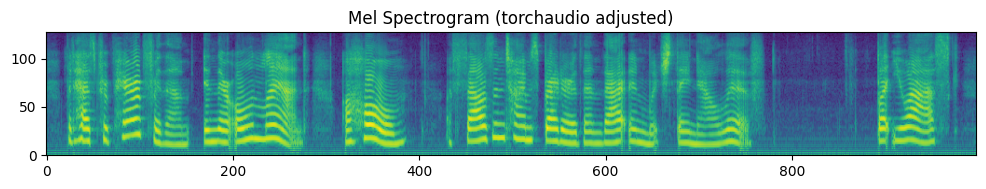

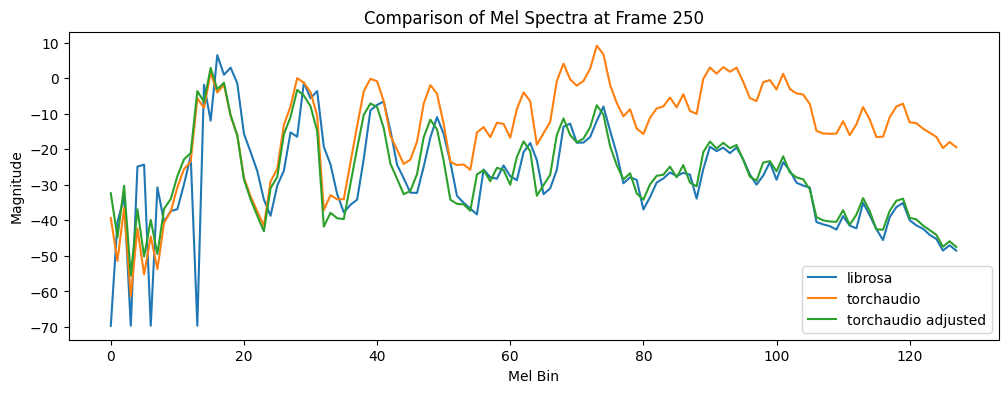

In [9]:
import numpy as np
import librosa
import soundfile as sf

def adjust_and_synthesize_audio(audiosignal, torchaudio_spectrogram_to_fit, torchaudio_spectrogram_to_adjust, sample_rate):
    
    def fit_polynomial_transform(M1, M2, order=5):
        b = M1 - M2
        f_bins, t_frames = M1.shape
        f = np.repeat(np.arange(f_bins), t_frames)
        # Create polynomial features up to the given order
        A = np.column_stack([f**i for i in range(order + 1)])
        b = b.flatten()
        A_transpose = A.T
        A_transpose_A = np.dot(A_transpose, A)
        A_transpose_b = np.dot(A_transpose, b)
        x = np.linalg.solve(A_transpose_A, A_transpose_b)
        return x  # coefficients of the polynomial

    def mel_2_audio(M):
        sr = sample_rate
        n_fft = 400
        hop_length = int(0.01 * sr)  # 10 ms
        win_length = int(0.025 * sr)  # 25 ms (= n_fft)
        window = 'hanning'
        linear_M = librosa.db_to_power(M)
        audio = librosa.feature.inverse.mel_to_audio(linear_M, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, n_iter=50, htk=True)
        return audio

    librosa_spectrogram_linear = librosa.feature.melspectrogram(
        y=audiosignal,
        sr=sample_rate,
        n_mels=128,
        hop_length=160,  # 10 ms = 160 * 1/16000
        n_fft=400,       # 25 ms = 400 * 1/16000
        center=False,
        htk=True,
        fmin=0.0,
        fmax=sample_rate / 2  # default Nyquist frequency
    )

    # torchaudio_spectrogram_to_fit_linear = np.exp(torchaudio_spectrogram_to_fit)
    # torchaudio_spectrogram_to_adjust_linear = np.exp(torchaudio_spectrogram_to_adjust)

    torchaudio_spectrogram_to_fit_db = torchaudio_spectrogram_to_fit
    torchaudio_spectrogram_to_adjust_db = torchaudio_spectrogram_to_fit
    librosa_spectrogram_linear_db = librosa.power_to_db(librosa_spectrogram_linear)

    # Calculate the polynomial transformation parameters
    coefficients = fit_polynomial_transform(np.array(librosa_spectrogram_linear_db), np.array(torchaudio_spectrogram_to_fit_db))

    # Apply the polynomial transformation to each frequency bin across all time frames
    frequency_indices = np.arange(torchaudio_spectrogram_to_adjust_db.shape[0]).reshape(-1, 1)
    adjustments = sum([coefficients[i] * frequency_indices**i for i in range(len(coefficients))])
    adjustments = np.tile(adjustments, (1, torchaudio_spectrogram_to_adjust_db.shape[1]))
    adjusted_spectrogram_db = torchaudio_spectrogram_to_adjust_db + adjustments

    # Resynthesize the audio from the adjusted spectrogram
    audio = mel_2_audio(adjusted_spectrogram_db)

    return audio, adjusted_spectrogram_db

# Example usage:
# Assuming you have defined 'audio_signal', 'M_torchaudio_db', and 'sample_rate' appropriately
audio_adjusted, M_torchaudio_db_transformed = adjust_and_synthesize_audio(audio_signal, M_torchaudio_db, M_torchaudio_db, sample_rate=16000)

# Save the adjusted audio
#sf.write('audio_adjusted_poly.wav', audio_adjusted, sample_rate)

# Plot the adjusted mel spectrogram
plt.figure(figsize=(12, 1.6))
plt.title('Mel Spectrogram (torchaudio adjusted)')
plt.imshow(M_torchaudio_db_transformed, aspect='auto', origin='lower', cmap='viridis')
plt.show()

# Plot the spectra at a specific frame
frame_index = 250
plt.figure(figsize=(12, 4))
plt.plot(M_librosa_db[:, frame_index], label='librosa')
plt.plot(M_torchaudio_db[:, frame_index], label='torchaudio')
plt.plot(M_torchaudio_db_transformed[:, frame_index], label='torchaudio adjusted')
plt.legend()
plt.title(f'Comparison of Mel Spectra at Frame {frame_index}')
plt.xlabel('Mel Bin')
plt.ylabel('Magnitude')
plt.show()

### histogram to get a sense of the correct scale (linear vs log, etc)

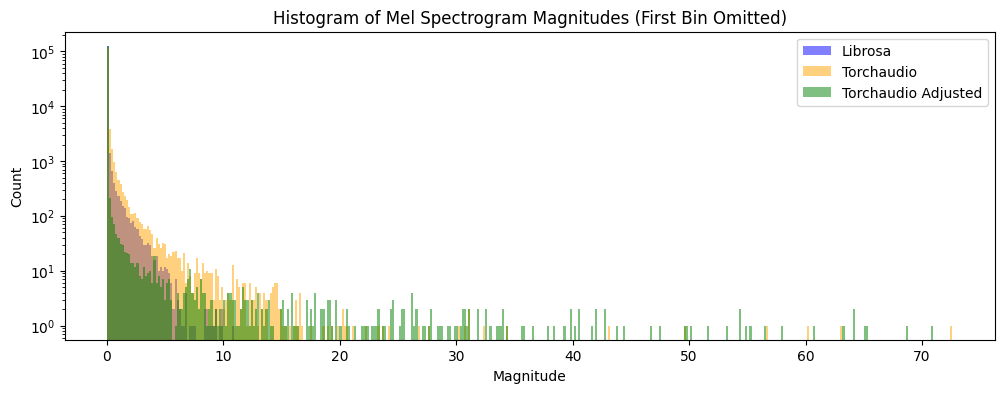

In [10]:
# Flatten the spectrogram arrays to 1D
mel_librosa_flat = mel_librosa.flatten()
M_flat = M.flatten()
M_torchaudio_linear_flat = (np.exp(M_torchaudio_db_transformed)).flatten()


# Calculate histogram bin edges
bins = np.histogram(np.hstack((mel_librosa_flat, M_flat)), bins=400)[1]  # Get only the bin edges

# Exclude the first bin by starting from the second bin's minimum edge
custom_bins = bins[0:]  # Start from the second bin

plt.figure(figsize=(12, 4))
plt.hist(mel_librosa_flat, bins=custom_bins, alpha=0.5, label='Librosa', color='blue', log=True)
plt.hist(M_flat, bins=custom_bins, alpha=0.5, label='Torchaudio', color='orange', log=True)
plt.hist(M_torchaudio_linear_flat, bins=custom_bins, alpha=0.5, label='Torchaudio Adjusted', color='green', log=True)
plt.legend()
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Histogram of Mel Spectrogram Magnitudes (First Bin Omitted)')
plt.show()

/home/bosfab01/.local/lib/python3.10/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


shape of torchaudio mel spectrogram: torch.Size([198, 128])
shape of torchaudio mel spectrogram: (128, 198)


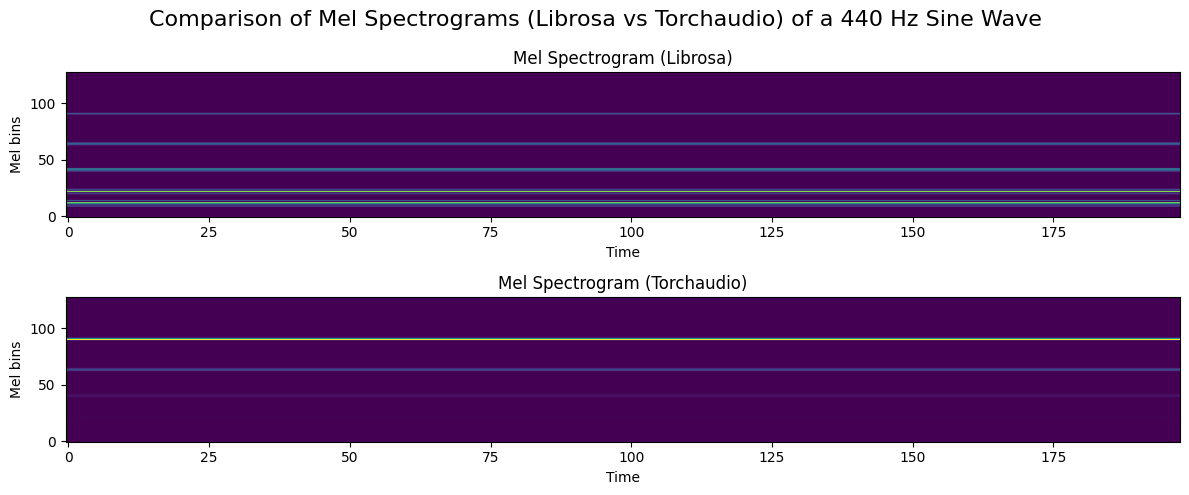

In [11]:
import matplotlib.pyplot as plt
import torchaudio
import librosa
import numpy as np
import torch

# Parameters
sr = 16000  # Sample rate
n_fft = 400  # FFT window size
hop_length = 160  # Hop length
win_length = 400  # Window length

# Generate a test signal consisting of 5 frequencies in the range audible to humans
freqs = [200, 400, 900, 1800, 3500]  # Hz
duration = 2.0  # seconds
t = np.linspace(0., duration, int(sr*duration), endpoint=False)
y = np.sum([0.5*np.sin(f*2*np.pi*t) for f in freqs], axis=0)

# Librosa Mel Spectrogram
S_librosa = librosa.feature.melspectrogram(
    y=y,
    sr=sample_rate,
    n_mels=128,
    hop_length=160,  # 10 ms = 160 * 1/16000
    n_fft=400,       # 25 ms = 400 * 1/16000
    center=False,
    htk=True,
    fmin=0.0,
    fmax=None        # default Nyquist frequency
)

# Torchaudio Mel Spectrogram
waveform = torch.tensor(y).unsqueeze(0)
S_torchaudio = torchaudio.compliance.kaldi.fbank(
    waveform, 
    sample_frequency=sr, 
    htk_compat=True, 
    use_energy=False, 
    window_type='hanning', 
    num_mel_bins=128, 
    dither=0.0, 
    frame_shift=10
)

# Plot the Mel spectrograms computed by both libraries using subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
plt.suptitle('Comparison of Mel Spectrograms (Librosa vs Torchaudio) of a 440 Hz Sine Wave', fontsize=16)

# Librosa Mel Spectrogram
axs[0].imshow(S_librosa, aspect='auto', origin='lower', cmap='viridis')
axs[0].set_title('Mel Spectrogram (Librosa)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mel bins')

# Torchaudio Mel Spectrogram
print('shape of torchaudio mel spectrogram:', S_torchaudio.shape)
S_torchaudio_np = S_torchaudio.numpy().T
print('shape of torchaudio mel spectrogram:', S_torchaudio_np.shape)
axs[1].imshow(np.exp(S_torchaudio_np), aspect='auto', origin='lower', cmap='viridis')
axs[1].set_title('Mel Spectrogram (Torchaudio)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Mel bins')

plt.tight_layout()
plt.show()


(128, 998)
(128, 998)
(128, 998)
(128, 1001)


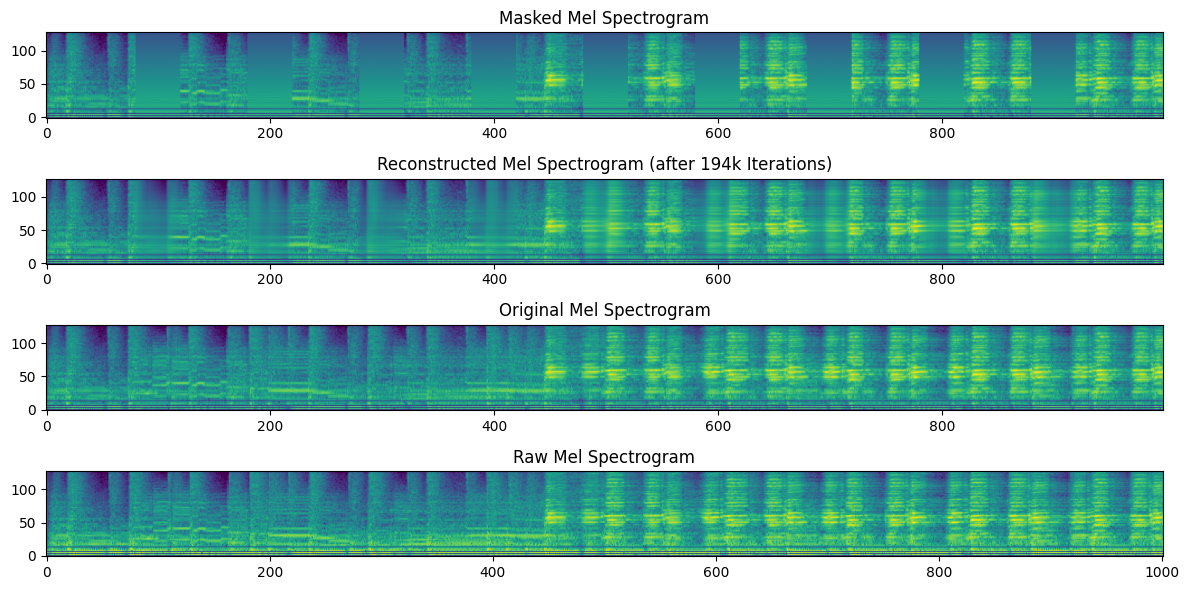

In [12]:
# plots of spectrograms of audios/madked_music.wav, audios/reconstructed_music_194.wav, audios/original_music.wav

# Load the audio files
masked_audio, _ = sf.read('audios/masked_music.wav')
reconstructed_audio_194, _ = sf.read('audios/reconstructed_music_194.wav')
original_audio, _ = sf.read('audios/original_music.wav')
raw_audio, _ = sf.read('audios/raw_music.wav')

# calculate the mel spectrograms USING LIBROSA
masked_mel = librosa.feature.melspectrogram(y=masked_audio, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
reconstructed_mel_194 = librosa.feature.melspectrogram(y=reconstructed_audio_194, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
original_mel = librosa.feature.melspectrogram(y=original_audio, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
raw_mel = librosa.feature.melspectrogram(y=raw_audio, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)

# print shapes
print(masked_mel.shape)
print(reconstructed_mel_194.shape)
print(original_mel.shape)
print(raw_mel.shape)

# turn into log scale
masked_mel = librosa.power_to_db(masked_mel)
reconstructed_mel_194 = librosa.power_to_db(reconstructed_mel_194)
original_mel = librosa.power_to_db(original_mel)
raw_mel = librosa.power_to_db(raw_mel)

# plot the mel spectrograms
plt.figure(figsize=(12, 6))

plt.subplot(4, 1, 1)
plt.imshow(masked_mel, aspect='auto', origin='lower')
plt.title('Masked Mel Spectrogram')

plt.subplot(4, 1, 2)
plt.imshow(reconstructed_mel_194, aspect='auto', origin='lower')
plt.title('Reconstructed Mel Spectrogram (after 194k Iterations)')

plt.subplot(4, 1, 3)
plt.imshow(original_mel, aspect='auto', origin='lower')
plt.title('Original Mel Spectrogram')

plt.subplot(4, 1, 4)
plt.imshow(raw_mel, aspect='auto', origin='lower')
plt.title('Raw Mel Spectrogram')

plt.tight_layout()

plt.show()


In [13]:
masked_speech, _ = sf.read('audios/masked_speech.wav')
reconstructed_speech, _ = sf.read('audios/reconstructed_speech.wav')
original_speech, _ = sf.read('audio_adjusted_poly.wav')
raw_speech, _ = sf.read('audios/raw_speech.wav')

# calculate the mel spectrograms USING LIBROSA
masked_mel = librosa.feature.melspectrogram(y=masked_speech, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
reconstructed_mel = librosa.feature.melspectrogram(y=reconstructed_speech, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
original_mel = librosa.feature.melspectrogram(y=original_speech, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)
raw_mel = librosa.feature.melspectrogram(y=raw_speech, sr=16000, n_mels=128, hop_length=160, n_fft=400, htk=True, fmin=0.0, fmax=8000)

# turn into log scale
masked_mel = librosa.power_to_db(masked_mel)
reconstructed_mel = librosa.power_to_db(reconstructed_mel)
original_mel = librosa.power_to_db(original_mel)
raw_mel = librosa.power_to_db(raw_mel)

# plot the mel spectrograms
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.imshow(masked_mel, aspect='auto', origin='lower')
plt.title('Masked Mel Spectrogram')

plt.subplot(4, 1, 2)
plt.imshow(reconstructed_mel, aspect='auto', origin='lower')
plt.title('Reconstructed Mel Spectrogram')

plt.subplot(4, 1, 3)
plt.imshow(original_mel, aspect='auto', origin='lower')
plt.title('Original Mel Spectrogram')

plt.subplot(4, 1, 4)
plt.imshow(raw_mel, aspect='auto', origin='lower')
plt.title('Raw Mel Spectrogram')

plt.tight_layout()

plt.show()



LibsndfileError: Error opening 'audio_adjusted_poly.wav': System error.